<a href="https://colab.research.google.com/github/samyon7/MyPrivate_MachineLearning/blob/master/Simple%20Pytorch/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d biancaferreira/african-wildlife

 98% 438M/448M [00:06<00:00, 98.4MB/s]
100% 448M/448M [00:06<00:00, 75.8MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/african-wildlife.zip', 'r')
zip_ref.extractall('Temporary')
zip_ref.close()

In [33]:
import os

root_dir = '/content/'
data_dir = '/content/Temporary'
print(os.listdir(data_dir))

['buffalo', 'rhino', 'elephant', 'zebra']


In [34]:
def rename_files(root_dir):
    classes = os.listdir(root_dir)
    for classes in classes:
        for file in os.listdir(root_dir + '/' + classes): 
            if file.endswith('jpg'):
                os.rename((root_dir + '/' + classes + '/' + file),(root_dir + '/' + classes + '/' + classes + "_" + file))

rename_files(data_dir)

In [35]:
from torch.utils.data import Dataset
from PIL import Image

def parse_species(fname):
    parts = fname.split('_')
    return parts[0]

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class FlowersDataset(Dataset):
    def __init__(self, root_dir, transform):
        super().__init__()
        self.root_dir = root_dir
        self.files = []
        self.classes = [fname for fname in os.listdir(root_dir) if fname != 'flowers']
        for classes in self.classes:                         
            for file in os.listdir(root_dir + '/' + classes): 
                if file.endswith('jpg'):
                    self.files.append(file)
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        species = parse_species(fname)
        fpath = os.path.join(self.root_dir, species, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(species)
        return img, class_idx

In [36]:
import torchvision.transforms as T

img_size = 300
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
transform = T.Compose([T.Resize((img_size, img_size)),
                       T.RandomCrop(64, padding=4, padding_mode='reflect'),
                       T.RandomHorizontalFlip(),
                       T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                       T.ToTensor(),
                       T.Normalize(*stats,inplace=True)])
dataset = FlowersDataset(data_dir, transform=transform)

In [37]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [41]:
from torch.utils.data import random_split

random_seed = 43
torch.manual_seed(random_seed)

val_pct = 0.15
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [42]:
train_ds, valid_ds= random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(1276, 225)

In [43]:
from torch.utils.data import DataLoader

batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [44]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

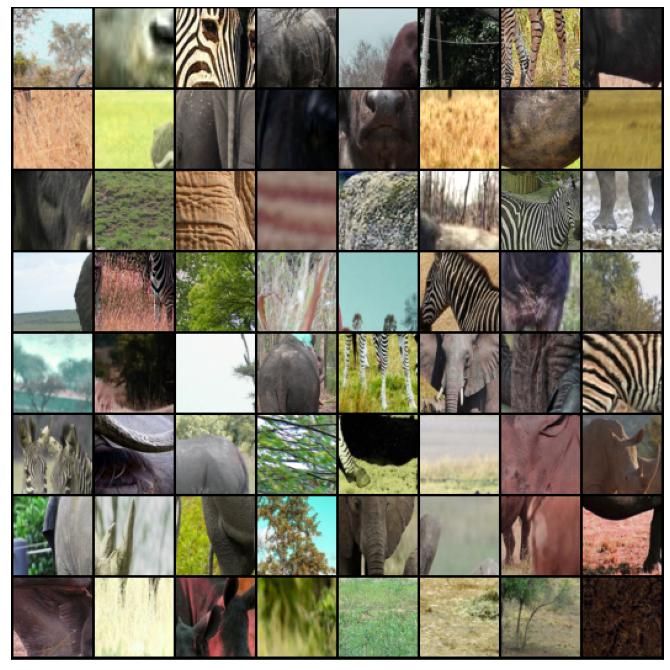

In [45]:
show_batch(train_dl)

In [46]:
def get_default_device():
    # Check the device accelerator
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [47]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [48]:
device = get_default_device()
device

device(type='cuda')

In [49]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [50]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  
        loss = F.cross_entropy(out, labels)  
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [52]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ClassifierModel(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)   
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)    
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))   
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),     
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))    
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [53]:
model = to_device(ClassifierModel(3, 5), device)
model

ClassifierModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(in

In [54]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [55]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.21480347216129303, 'val_loss': 1.6107786893844604}]

In [59]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [60]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0],last_lr: 0.00050, train_loss: 1.5025, val_loss: 1.3656, val_acc: 0.3365



Epoch [1],last_lr: 0.00080, train_loss: 1.4806, val_loss: 1.2772, val_acc: 0.3871



Epoch [2],last_lr: 0.00129, train_loss: 1.4422, val_loss: 1.5580, val_acc: 0.3328



Epoch [3],last_lr: 0.00196, train_loss: 1.4208, val_loss: 1.6520, val_acc: 0.3459



Epoch [4],last_lr: 0.00277, train_loss: 1.4667, val_loss: 1.2284, val_acc: 0.4184



Epoch [5],last_lr: 0.00369, train_loss: 1.3815, val_loss: 1.5003, val_acc: 0.3770



Epoch [6],last_lr: 0.00467, train_loss: 1.4753, val_loss: 1.5428, val_acc: 0.4042



Epoch [7],last_lr: 0.00568, train_loss: 1.5661, val_loss: 1.4914, val_acc: 0.3524



Epoch [8],last_lr: 0.00666, train_loss: 1.6813, val_loss: 1.8990, val_acc: 0.3860



Epoch [9],last_lr: 0.00759, train_loss: 1.7062, val_loss: 2.3777, val_acc: 0.3184



Epoch [10],last_lr: 0.00840, train_loss: 1.8964, val_loss: 5.3080, val_acc: 0.2692



Epoch [11],last_lr: 0.00908, train_loss: 1.6471, val_loss: 1.6483, val_acc: 0.3004



Epoch [12],last_lr: 0.00958, train_loss: 1.6170, val_loss: 1.3649, val_acc: 0.3574



Epoch [13],last_lr: 0.00989, train_loss: 1.7597, val_loss: 1.6978, val_acc: 0.3095



Epoch [14],last_lr: 0.01000, train_loss: 1.9500, val_loss: 1.8300, val_acc: 0.3146



Epoch [15],last_lr: 0.00998, train_loss: 1.6420, val_loss: 1.4180, val_acc: 0.3589



Epoch [16],last_lr: 0.00992, train_loss: 1.7269, val_loss: 3.2153, val_acc: 0.3175



Epoch [17],last_lr: 0.00982, train_loss: 1.5564, val_loss: 1.5507, val_acc: 0.2707



Epoch [18],last_lr: 0.00968, train_loss: 1.7653, val_loss: 1.4919, val_acc: 0.2887



Epoch [19],last_lr: 0.00950, train_loss: 1.4455, val_loss: 1.3069, val_acc: 0.3771



Epoch [20],last_lr: 0.00929, train_loss: 1.4772, val_loss: 1.2608, val_acc: 0.4456



Epoch [21],last_lr: 0.00905, train_loss: 1.3452, val_loss: 1.2609, val_acc: 0.3456



Epoch [22],last_lr: 0.00877, train_loss: 1.4561, val_loss: 1.4495, val_acc: 0.4093



Epoch [23],last_lr: 0.00846, train_loss: 1.3708, val_loss: 1.2663, val_acc: 0.3965



Epoch [24],last_lr: 0.00812, train_loss: 1.4290, val_loss: 1.5436, val_acc: 0.3679



Epoch [25],last_lr: 0.00775, train_loss: 1.3399, val_loss: 1.2090, val_acc: 0.4248



Epoch [26],last_lr: 0.00737, train_loss: 1.3533, val_loss: 1.3424, val_acc: 0.3835



Epoch [27],last_lr: 0.00697, train_loss: 1.3362, val_loss: 1.2725, val_acc: 0.4246



Epoch [28],last_lr: 0.00655, train_loss: 1.3340, val_loss: 1.7890, val_acc: 0.3521



Epoch [29],last_lr: 0.00611, train_loss: 1.4201, val_loss: 1.3090, val_acc: 0.4198



Epoch [30],last_lr: 0.00567, train_loss: 1.3213, val_loss: 1.3507, val_acc: 0.3718



Epoch [31],last_lr: 0.00522, train_loss: 1.3557, val_loss: 1.3181, val_acc: 0.4185



Epoch [32],last_lr: 0.00478, train_loss: 1.2688, val_loss: 1.3795, val_acc: 0.3915



Epoch [33],last_lr: 0.00433, train_loss: 1.3862, val_loss: 1.3211, val_acc: 0.3953



Epoch [34],last_lr: 0.00389, train_loss: 1.3916, val_loss: 1.3110, val_acc: 0.4027



Epoch [35],last_lr: 0.00345, train_loss: 1.3442, val_loss: 1.2052, val_acc: 0.4740



Epoch [36],last_lr: 0.00303, train_loss: 1.2855, val_loss: 1.2639, val_acc: 0.4348



Epoch [37],last_lr: 0.00263, train_loss: 1.2535, val_loss: 1.2721, val_acc: 0.4392



Epoch [38],last_lr: 0.00225, train_loss: 1.2643, val_loss: 1.2265, val_acc: 0.3899



Epoch [39],last_lr: 0.00188, train_loss: 1.2592, val_loss: 1.2770, val_acc: 0.4207



Epoch [40],last_lr: 0.00154, train_loss: 1.2660, val_loss: 1.2199, val_acc: 0.4741



Epoch [41],last_lr: 0.00123, train_loss: 1.2270, val_loss: 1.1543, val_acc: 0.4857



Epoch [42],last_lr: 0.00095, train_loss: 1.2370, val_loss: 1.2328, val_acc: 0.4326



Epoch [43],last_lr: 0.00071, train_loss: 1.2047, val_loss: 1.2302, val_acc: 0.3729



Epoch [44],last_lr: 0.00050, train_loss: 1.2215, val_loss: 1.2016, val_acc: 0.4452



Epoch [45],last_lr: 0.00032, train_loss: 1.2053, val_loss: 1.2103, val_acc: 0.4285



Epoch [46],last_lr: 0.00018, train_loss: 1.1974, val_loss: 1.1444, val_acc: 0.4919



Epoch [47],last_lr: 0.00008, train_loss: 1.2214, val_loss: 1.1702, val_acc: 0.4959



Epoch [48],last_lr: 0.00002, train_loss: 1.1953, val_loss: 1.1265, val_acc: 0.5191



Epoch [49],last_lr: 0.00000, train_loss: 1.1744, val_loss: 1.2309, val_acc: 0.4416
CPU times: user 29.2 s, sys: 15.4 s, total: 44.7 s
Wall time: 24min 13s


In [67]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

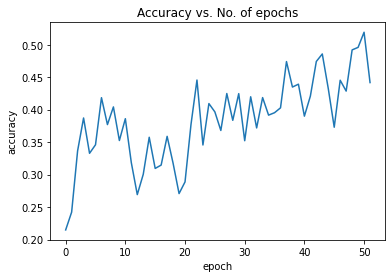

In [68]:
plot_accuracies(history)

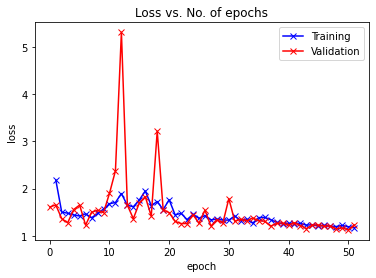

In [64]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

Label: elephant , Predicted: buffalo


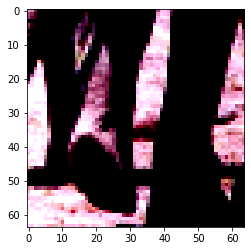

In [71]:
# Test prediction onto model!
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

img, label = valid_ds[156]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))